If you don't want to install all the packages Unsloth's [Docker image](https://hub.docker.com/r/unsloth/unsloth) is here! Start training with no setup & environment issues. [Here the Guide](https://docs.unsloth.ai/new/how-to-train-llms-with-unsloth-and-docker).

In [10]:
# !pip install -U tensorflow -q
# !pip install -U unsloth vllm -q
# !pip install bitsandbytes faccelerate peft -q

In [11]:
import unsloth
from unsloth import FastVisionModel, is_bfloat16_supported
from unsloth.trainer import UnslothVisionDataCollator
import argparse
import logging
import sys
from transformers import TextStreamer
import time
import torch
from datasets import load_dataset
from huggingface_hub import login
from trl import SFTTrainer, SFTConfig

In [12]:
OUTPUT_DIR = "llama-3.2-finetuned"
MODEL_NAME = "unsloth/Llama-3.2-11B-Vision-Instruct"

# Info about the system

In [13]:
# Log system info
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA L4
GPU memory: 23.6 GB


In [14]:
model, tokenizer = FastVisionModel.from_pretrained(
    model_name = MODEL_NAME,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)

==((====))==  Unsloth 2025.10.3: Fast Mllama patching. Transformers: 4.56.1. vLLM: 0.11.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 21.951 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

# Apply LoRA

In [15]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers = True,
    finetune_language_layers = True,
    finetune_attention_modules = True,
    finetune_mlp_modules = True,
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias="none",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


# Data prepraration

In [16]:
dataset = load_dataset("unsloth/Radiology_mini", split="train")

In [17]:
# Split dataset
dataset = dataset.train_test_split(test_size=0.1, seed=3407)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

print(f"Train samples: {len(train_dataset)}, Eval samples: {len(eval_dataset)}")

Train samples: 1780, Eval samples: 198


In [18]:
def preprocess(sample, instruction):
    """Convert dataset sample to conversation format"""
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": sample["caption"]}
            ]
        },
    ]
    return {"messages": conversation}

In [19]:
# Convert to conversation format
print("Converting dataset to conversation format")

system = "You are an expert radiographer. Describe accurately what you see in this image."
print(f"Using '{system}' as system prompt")

converted_train = [preprocess(sample, system) for sample in train_dataset]
converted_eval = [preprocess(sample, system) for sample in eval_dataset]

Converting dataset to conversation format
Using 'You are an expert radiographer. Describe accurately what you see in this image.' as system prompt


In [20]:
print(tokenizer.chat_template)

{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- Find out if there are any images #}
{% set image_ns = namespace(has_images=false) %}      
{%- for message in messages %}
    {%- for content in message['content'] %}
        {%- if content['type'] == 'im

In [21]:
converted_train[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiographer. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=514x1212>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Esophagogram anteroposterior view reveals extravasation of contrast from the distal third of esophagus on left side'}]}]}

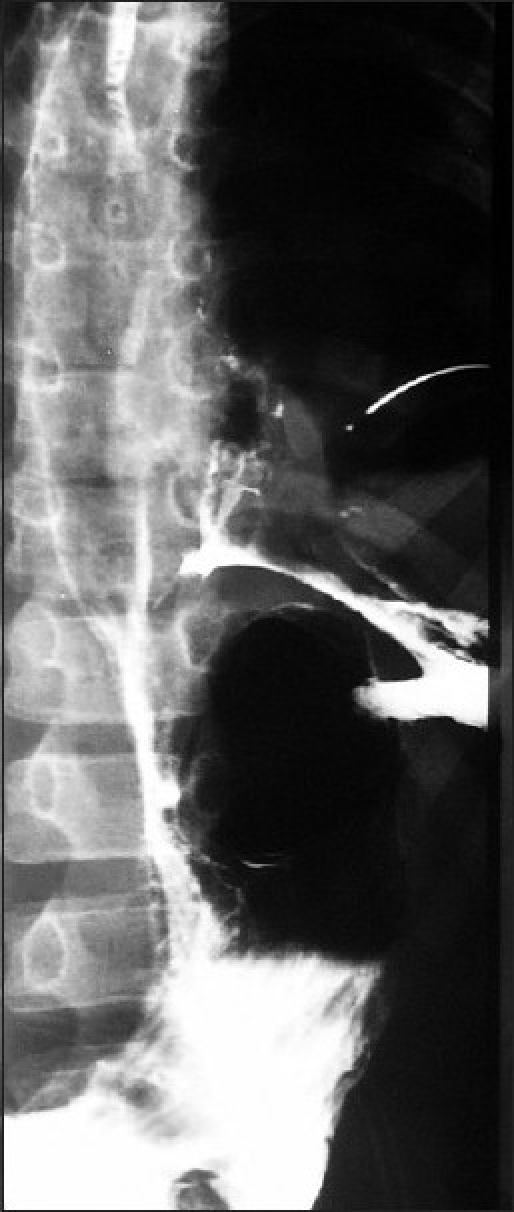

In [22]:
converted_train[0]['messages'][0]['content'][1]['image']

# Start Training

In [23]:
# Build training args dynamically to avoid None values
training_config = {
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 4,
    "warmup_steps": 5,
    "learning_rate": 2e-4,
    "fp16": False,
    "bf16": True,
    "logging_steps": 10,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "eval_strategy": "steps",
    "eval_steps": 50,
    "save_strategy": "best",
    "save_total_limit": 2,
    "load_best_model_at_end": True,
    "metric_for_best_model": "eval_loss",
    "seed": 3407,
    "output_dir": OUTPUT_DIR,
    "report_to": "none",
    # Vision-specific settings
    "remove_unused_columns": False,
    "dataset_text_field": "",
    "dataset_kwargs": {"skip_prepare_dataset": True},
    "max_length": 2048,
    "max_steps": 30,
    # "num_train_epochs": 3 # Uncomment max_steps to use
}

training_args = SFTConfig(**training_config)

In [24]:
# Create trainer
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=converted_train,
    eval_dataset=converted_eval,
    args=training_args,
)


In [25]:
# Show GPU stats
if torch.cuda.is_available():
    gpu_stats = torch.cuda.get_device_properties(0)
    start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
    print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
    print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 21.951 GB.
15.047 GB of memory reserved.


In [26]:
# Train
print("Starting training...")
trainer_stats = trainer.train()
print("Training completed successfully!")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'bos_token_id': 128000}.


Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,780 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400 of 10,737,395,235 (0.63% trained)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss


Unsloth: Will smartly offload gradients to save VRAM!
Training completed successfully!


In [27]:
model.save_pretrained(OUTPUT_DIR)  # Local saving
tokenizer.save_pretrained(OUTPUT_DIR)

[]

In [28]:
# Show final stats
if torch.cuda.is_available():
    used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
    used_percentage = round(used_memory / max_memory * 100, 3)
    lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
    print(f"Training time: {trainer_stats.metrics['train_runtime']:.2f} seconds")
    print(f"Training time: {round(trainer_stats.metrics['train_runtime']/60, 2)} minutes")
    print(f"Peak reserved memory = {used_memory} GB.")
    print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
    print(f"Peak reserved memory % of max memory = {used_percentage} %.")
    print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

Training time: 312.11 seconds
Training time: 5.2 minutes
Peak reserved memory = 15.047 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 68.548 %.
Peak reserved memory for training % of max memory = 0.0 %.


# Testing the model

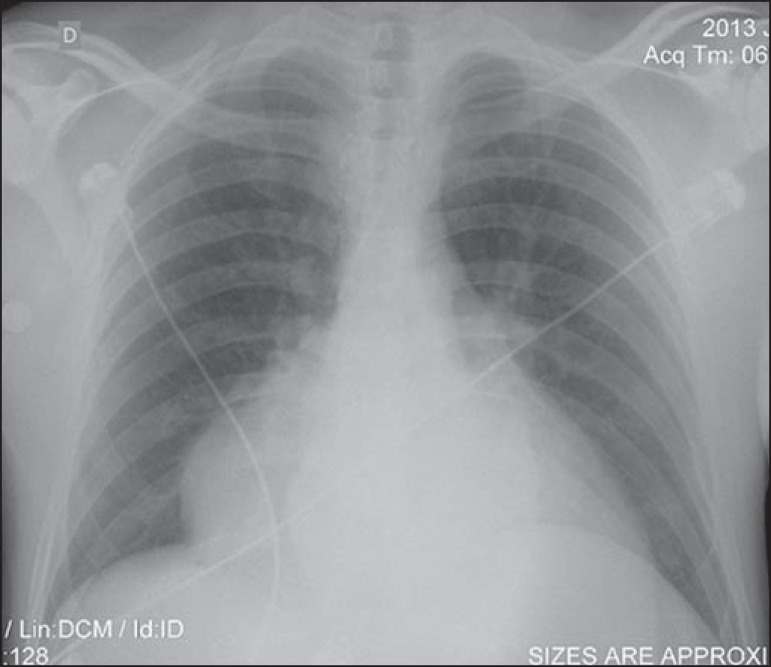

In [29]:
eval_dataset[1]["image"]

In [30]:
# from unsloth import FastVisionModel
# model, tokenizer = FastVisionModel.from_pretrained(
#     model_name = OUTPUT_DIR, # YOUR MODEL YOU USED FOR TRAINING
#     load_in_4bit = True, # Set to False for 16bit LoRA
#     device_map="auto"
# )
FastVisionModel.for_inference(model) # Enable for inference!

image = eval_dataset[1]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This radiograph demonstrates multiple rib fractures consistent with non-accidental trauma.<|eot_id|>
